[*********************100%***********************]  1 of 1 completed

[[ 4494.64990234]
 [ 4546.20019531]
 [ 4732.35009766]
 ...
 [23486.84960938]
 [23591.94921875]
 [23519.34960938]]
[[0.08316995]
 [0.08534581]
 [0.09320294]
 ...
 [0.88480422]
 [0.88924033]
 [0.886176  ]]
Epoch 1/20



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0101 - val_loss: 8.4039e-04
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.7504e-04 - val_loss: 2.6962e-04
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.3281e-04 - val_loss: 4.6110e-04
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7276e-04 - val_loss: 3.4780e-04
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1770e-04 - val_loss: 0.0019
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1021e-04 - val_loss: 7.9676e-04
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0400e-04 - val_loss: 3.8915e-04
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5057e-04 - val_loss: 2.4012e-04
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9428e-04 - val_loss: 2.1335e-04
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1501e-04 - val_loss: 0.0010
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0632e-04 -

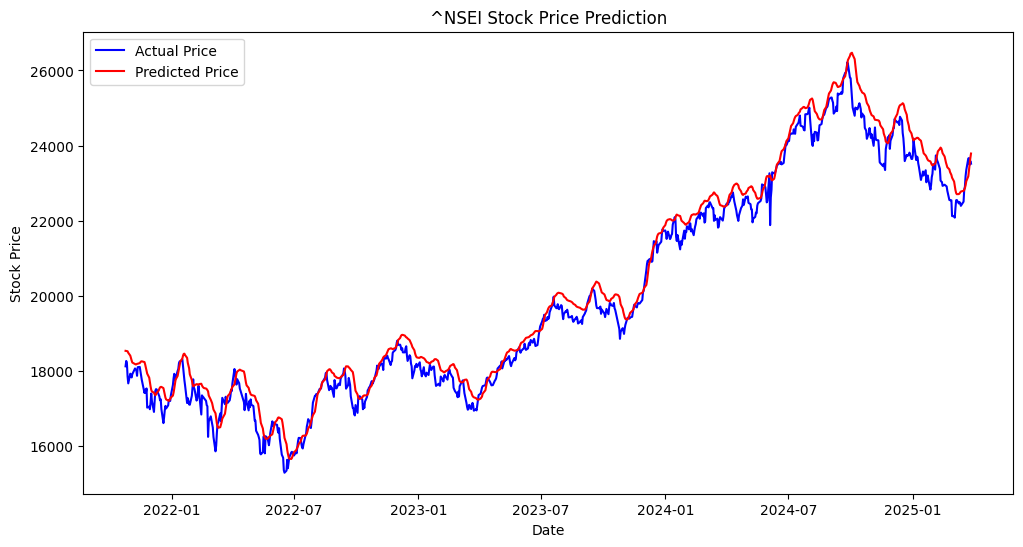

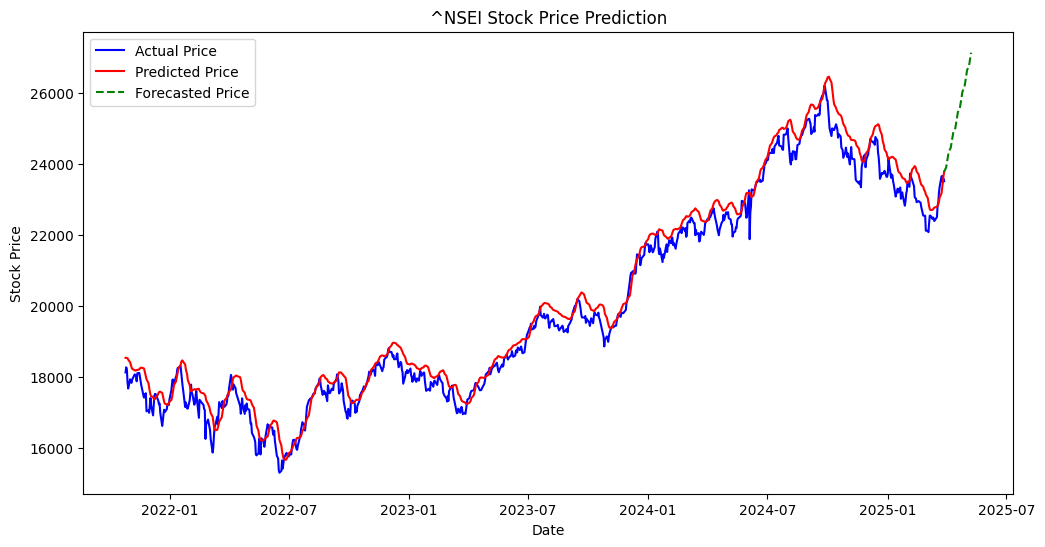

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42)

# Fetch Stock Data
def fetch_stock_data(ticker):
  stock = yf.download(ticker, period='max')
  return stock['Close']  # Use closing price for forecasting

# Prepare dataset for LSTM
def prepare_data(data, time_step=60):
  scaler = MinMaxScaler(feature_range =(0,1))
  data_scaled = scaler.fit_transform(np.array(data).reshape(-1,1)) # 1D reshape
  print(np.array(data))
  print(data_scaled)

  X,y = [],[]

  for i in range(time_step,len(data_scaled)):
    X.append(data_scaled[i-time_step:i,0])
    y.append(data_scaled[i,0])

  return np.array(X), np.array(y), scaler


def build_lstm_model(input_shape):
  #  this stacked LSTM - two LSTM layer used
    model=Sequential([
        LSTM(50, return_sequences =True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer ='adam', loss = 'mean_squared_error')
    return model

# Predict future stock prices
def predict_future(model, data, time_step, scaler, days=7):
  last_days = data.reshape(1,-1,1) # ensure 3D shape for LSTM input
  predictions =[]

  for _ in range(days):
    pred = model.predict(last_days, verbose=0)
    predictions.append(pred[0,0])  # extract scalar prediction

    # Append predicted value correctly
    last_days = np.append(last_days[:,1:,:],pred.reshape(1,1,1), axis=1)

  return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

# Main execution
ticker ='^NSEI'   # change to any stock symbol
df = fetch_stock_data(ticker)
X, y, scaler = prepare_data(df)

# Train-test split
train_size = int(len(X)*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0]),X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0]),X_test.shape[1],1)

# Build and train model
model = build_lstm_model((X_train.shape[1],1))
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 32)

# Predict on test data
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Print model performance
train_loss = h.history['loss'][-1]
val_loss = h.history['val_loss'][-1]
print(f"Final Training Loss: {train_loss:.6f}")
print(f"Final Validation Loss: {val_loss:.6f}")

# Print actual vs predicted price for last few days
print("\nLast 10 Actual vs Predicted Prices:")
for actual, pred in zip(y_test_rescaled[-10:], y_pred_rescaled[-10:]):
    print(f"Actual: {actual[0]:.2f}, Predicted: {pred[0]:.2f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label = "Actual Price", color = "blue")
plt.plot(df.index[-len(y_test):],y_pred_rescaled, label = "Predicted Price", color = "red")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f"{ticker} Stock Price Prediction")
plt.legend()
plt.show()

# Future forecast
future_preds = predict_future(model, X[-1], 60, scaler, days=30)

# Create future date range
future_dates = pd.date_range(start=df.index[-1], periods=30, freq='B') # 'B' ensures business days only

# Plot actual, predicted, and forecasted prices
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label = "Actual Price", color = "blue")
plt.plot(df.index[-len(y_test):],y_pred_rescaled, label = "Predicted Price", color = "red")
plt.plot(future_dates, future_preds, label="Forecasted Price", color="green", linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f"{ticker} Stock Price Prediction")
plt.legend()
plt.show()
